In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.utils import load_state_dict_from_url

Resnet was simply an extension of VGG
https://arxiv.org/pdf/1409.1556.pdf

# Evaluating the dataset


Let's work on testing it on some popular dataset.

Let's start with CIFAR

## Gather your dataset
- In this case, we want CIFAR dataset.
- Fortunately, this is already built-in from torchvision package

In [32]:
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transform to augment the data. 
# Transform #1 = we want to convert everything into tensor format so that we can streamline pytorch packages
# Transform #2 = Normalize. This is used for data cleaning so that you can help the model perform better.
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

#Load your MNIST Dataset
# If you check the documentation of MNIST method, 
#              argument #1 = directory to save the fetched dataset
#              argument #2 (download)  = do we download if you don't have on the said directory?
#              argument #3 (train)     = what type of dataset?
#              argument #4 (transform) = which transformation do you like to do? 
train_set = datasets.CIFAR10('drive/My Drive/cifar', download=True, train=True, transform=transform)
test_set = datasets.CIFAR10('drive/My Drive/cifar', download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
train_set

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: drive/My Drive/cifar
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

From above, we see that the `Dataset` object is like a folder structure. It provides you a mechanism to see its properties. 

*Recall*: In our previous lesson, we showed that training models in pytorch was done using the built-in `for` loop of Python. Our dataset that time was just using list of random numbers. 

But now that we are using real-world dataset via `Dataset` object. So how do we use it for model training?

We can use `DataLoader` utility to convert the dataset object into an `iterable` object which you can use within `for` loop later on.


In [53]:
# This is a function for you to change it from the dataset structure above into something iterable for the looping statement later on.
trainDataLoader = torch.utils.data.DataLoader(train_set, batch_size=16*4, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(test_set, batch_size=16*4, shuffle=True)

#Increasing batchsize makes training faster. However, due to the nature of SGD, it also creates more instabiltiy during training.

Let's try to check what does one iteration look like.

In [54]:
trainIter = iter(trainDataLoader) # Convert it into python iterable built-in object

images, labels = trainIter.next() #Get the next element

print(images.shape, labels.shape)

torch.Size([64, 3, 32, 32]) torch.Size([64])


As you can see from above, our Image is four dimensional. Additionally, pytorch dimensional format is as follows:  
dim0 = batch size  (i.e. number of images in one batch)  
dim1 = no. of channels  (i.e. number of color channel if you may, e.g. R,G,B)  
dim2 = height (i.e. how tall the photo in pixel)   
dim3 = width  (i.e. how wide the photo in pixel)  

Note: If you are coming from tensorflow, they have different arrangement of dimension esp no. of channel


Also, note that labels is of shape 64. It's because, we set that the batch_size is 64. Thus, we get 64 images and 64 labels.

## Visualize the dataset
This is how our dataset looks like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


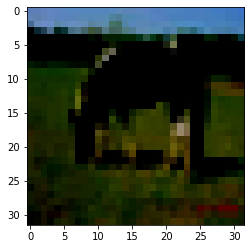

In [55]:
plt.gray()
plt.imshow(images[0].numpy().transpose([1,2,0])) #Note: We get the image 0 from the batch. Thus, it becomes 3 dim. We transpose to fix the dims appropriate for matplotlib

This is how our labels look like.

In CIFAR10. The labels only ranges from 0 to 9.

In [56]:
labels[0].numpy().tolist()

7

## Model Configurations
- This is where we configure our model depending on the context of the data we want
- Note in this case we would use resnet50

In [57]:
from vgg19 import vgg19
from resnet50 import resnet50

In [58]:
seed = 24 #Fave Number. Kobe == 24
torch.manual_seed(seed) # This is set in order to have reproducible and comparable results

# VGG. If you want VGG Uncomment below and comment out resnet
#model = vgg19(pretrained=True)
#num_ftrs = model.classifier[-1].in_features
# Here the size of each output sample is set to 10.
#model.classifier[-1] = nn.Linear(num_ftrs, 10)

# Resnet
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model.to(device) #Transfer to GPU

# nn.DataParallel would automatically detect how many GPU your machine have. 
# Increasing number of parallelism causes more instability on cost function minimization.
model = nn.DataParallel(model) # Make it work on Multi-GPU setup. (note: Single machine/node only)



epochs = 10 # Number of times it would repeat the whole training process

In [64]:
# Define the cost function
# criterion = torch.nn.MSELoss(reduction='sum')
criterion = nn.CrossEntropyLoss() #This is good for classification task

# Define how we would update the weights
optimizer = torch.optim.SGD(model.parameters(),lr=4e-3,momentum=0.9)

# LRFinder
Let's use LRFinder as our guideline on setting the learning rate


Learning rate search finished. See the graph with {finder_name}.plot()


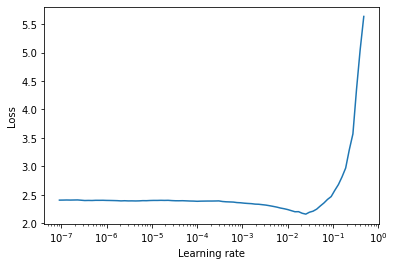

In [63]:
from lr_finder import LRFinder

finder = LRFinder(model, optimizer=optimizer, criterion=criterion, device=device)

finder.range_test(trainDataLoader,end_lr=1, num_iter=100)

finder.plot()

finder.reset()

In [65]:
from tqdm import tqdm

def train_fn(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    
    for batch, data in tqdm(enumerate(data_loader), total=len(data_loader)): #tqdm == progress bar
        images = data[0].to(device) #The CIFAR Dataset returns a Tuple. Zero-index is the image
        labels = data[1].to(device) # Index-1 is the label (in this case, the labels ranges from 0-9)
        
        model.zero_grad()
        output = model(images) #Note: The output here is not yet a probability. Rather it's still need to go thru Softmax
        loss = criterion(output, labels) # We do the softmax here. CrossEntropyLoss = NllLoss + Softmax
        
        loss.backward()
        
        optimizer.step()    
        
        if scheduler:
            scheduler.step()


def eval_fn(data_loader, model, device):
    model.eval()
    
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for batch, data in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = data[0].to(device)
            labels = data[1].to(device)

            output = model(images) #Note: The output here is not yet a probability. Rather it's still need to go thru Softmax
            loss = criterion(output, labels) # We do the softmax here. CrossEntropyLoss = NllLoss + Softmax

            fin_targets.extend(labels.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.softmax(output, dim=1).cpu().detach().numpy().tolist()) # We also do softmax here
    
    return fin_outputs, fin_targets

In [ ]:
from sklearn import metrics

best_accuracy=0
for epoch in range(epochs):
        train_fn(trainDataLoader, model, optimizer, device)
        
        outputs, targets = eval_fn(testDataLoader, model, device)
        
        preds = np.argmax(outputs, 1) #In this case, we have 10 probabilities. We take the index that has the highest probability
        
        accuracy = metrics.accuracy_score(preds, targets)
        print(f"Accuracy: {accuracy}")
        
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "model.pth")        

100%|██████████| 157/157 [00:10<00:00, 14.65it/s]


Accuracy: 0.7892


  0%|          | 1/782 [00:00<01:23,  9.32it/s]

Accuracy: 0.7374


 39%|███▉      | 307/782 [00:35<00:54,  8.69it/s]